In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

In [3]:
mypath = '/content/drive/MyDrive/SOS/TRAIN'

In [4]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [5]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
# df = pd.DataFrame({"path":full_path,'file_name':file_name})
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
NONE    36
O       46
S       39
dtype: int64

In [6]:
#cek sample datanya
df.head()

,path,file_name,tag
0,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (3).jpg,S
1,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (2).jpg,S
2,/content/drive/MyDrive/SOS/TRAIN/S/body white ...,body white (2).jpg,S
3,/content/drive/MyDrive/SOS/TRAIN/S/body dot (2...,body dot (2).jpg,S
4,/content/drive/MyDrive/SOS/TRAIN/S/body dot (3...,body dot (3).jpg,S


In [7]:
import cv2

# check image shape-nya
img = cv2.imread('/content/drive/MyDrive/SOS/TRAIN/S/WIN_20220724_06_24_15_Pro.jpg')
print(type(img))
# <class 'numpy.ndarray'>

print(img.shape)
# (788, 789, 3)

<class 'numpy.ndarray'>
(240, 320, 3)


In [8]:
s = df.loc[df['tag'] == 'S']
s.head()

,path,file_name,tag
0,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (3).jpg,S
1,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (2).jpg,S
2,/content/drive/MyDrive/SOS/TRAIN/S/body white ...,body white (2).jpg,S
3,/content/drive/MyDrive/SOS/TRAIN/S/body dot (2...,body dot (2).jpg,S
4,/content/drive/MyDrive/SOS/TRAIN/S/body dot (3...,body dot (3).jpg,S


In [9]:
o = df.loc[df['tag'] == 'O']
o.head()

,path,file_name,tag
39,/content/drive/MyDrive/SOS/TRAIN/O/body dot (4...,body dot (4).jpg,O
40,/content/drive/MyDrive/SOS/TRAIN/O/wall white ...,wall white (4).jpg,O
41,/content/drive/MyDrive/SOS/TRAIN/O/body white ...,body white (3).jpg,O
42,/content/drive/MyDrive/SOS/TRAIN/O/body white ...,body white (2).jpg,O
43,/content/drive/MyDrive/SOS/TRAIN/O/body white ...,body white (4).jpg,O


In [10]:
none = df.loc[df['tag'] == 'NONE']
none.head()

,path,file_name,tag
85,/content/drive/MyDrive/SOS/TRAIN/NONE/IMG_0945...,IMG_0945.JPG,NONE
86,/content/drive/MyDrive/SOS/TRAIN/NONE/IMG_0947...,IMG_0947.JPG,NONE
87,/content/drive/MyDrive/SOS/TRAIN/NONE/WIN_2022...,WIN_20220724_06_30_31_Pro.jpg,NONE
88,/content/drive/MyDrive/SOS/TRAIN/NONE/WIN_2022...,WIN_20220724_06_30_34_Pro.jpg,NONE
89,/content/drive/MyDrive/SOS/TRAIN/NONE/WIN_2022...,WIN_20220724_06_30_37_Pro.jpg,NONE


In [11]:
df = pd.concat([s, o, none], ignore_index=True)
df.head()

,path,file_name,tag
0,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (3).jpg,S
1,/content/drive/MyDrive/SOS/TRAIN/S/wall white ...,wall white (2).jpg,S
2,/content/drive/MyDrive/SOS/TRAIN/S/body white ...,body white (2).jpg,S
3,/content/drive/MyDrive/SOS/TRAIN/S/body dot (2...,body dot (2).jpg,S
4,/content/drive/MyDrive/SOS/TRAIN/S/body dot (3...,body dot (3).jpg,S


# Tensorflow

In [1]:
mypath = '/content/drive/MyDrive/SOS/TRAIN'

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
import tensorflow as tf
from tensorflow import keras

train_ds = tf.keras.utils.image_dataset_from_directory(
  mypath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 121 files belonging to 3 classes.
Using 97 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  mypath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 121 files belonging to 3 classes.
Using 24 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['NONE', 'O', 'S']


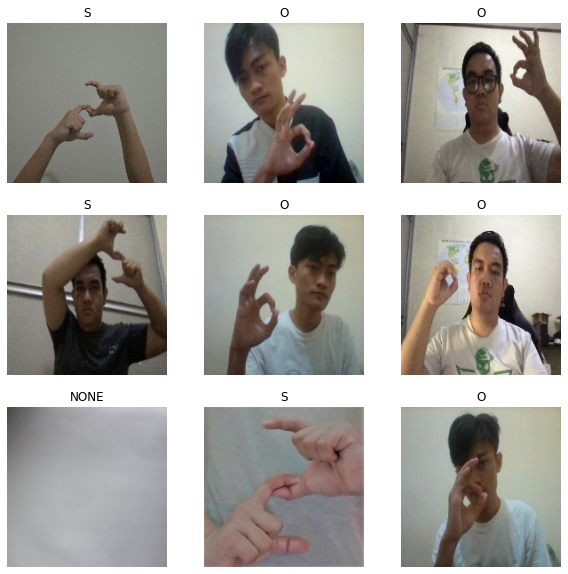

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

In [10]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0017429759 0.99960065


In [17]:
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

tf.keras.backend.clear_session()

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [20]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/15
4/4 [==============================] - 5s 962ms/step - loss: 1.1218 - accuracy: 0.3299 - val_loss: 1.0422 - val_accuracy: 0.5000
Epoch 2/15
4/4 [==============================] - 4s 826ms/step - loss: 1.1088 - accuracy: 0.2577 - val_loss: 1.0496 - val_accuracy: 0.5000
Epoch 3/15
4/4 [==============================] - 4s 827ms/step - loss: 1.1129 - accuracy: 0.2784 - val_loss: 1.0364 - val_accuracy: 0.5000
Epoch 4/15
4/4 [==============================] - 4s 829ms/step - loss: 1.1202 - accuracy: 0.2784 - val_loss: 1.0194 - val_accuracy: 0.5000
Epoch 5/15
4/4 [==============================] - 4s 836ms/step - loss: 1.1291 - accuracy: 0.2784 - val_loss: 0.9987 - val_accuracy: 0.5000
Epoch 6/15
4/4 [==============================] - 4s 1s/step - loss: 1.2042 - accuracy: 0.2784 - val_loss: 0.9933 - val_accuracy: 0.5000
Epoch 7/15
4/4 [==============================] - 4s 1s/step - loss: 1.1631 - accuracy: 0.2784 - val_loss: 0.9981 - val_accuracy: 0.5000
Epoch 8/15
4/4 [==========

KeyboardInterrupt: ignored

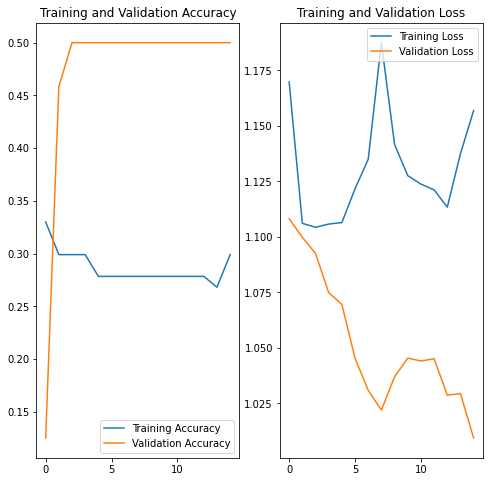

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
model.save('/content/drive/MyDrive/Model_dis_2/model_baru_v2.h5')

# Using Augmentation

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

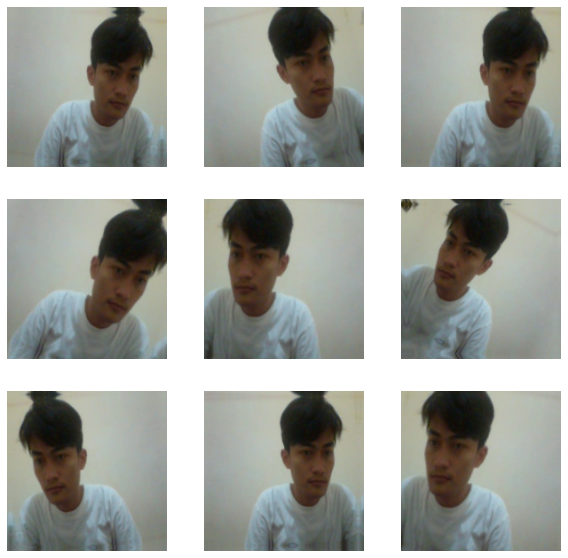

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [32]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [35]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 4s 1s/step - loss: 2.2897 - accuracy: 0.3837 - val_loss: 1.5023 - val_accuracy: 0.5238
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 1.4500 - accuracy: 0.2558 - val_loss: 1.2724 - val_accuracy: 0.0952
Epoch 3/15
3/3 [==============================] - 3s 953ms/step - loss: 1.1760 - accuracy: 0.3256 - val_loss: 1.1365 - val_accuracy: 0.0952
Epoch 4/15
3/3 [==============================] - 3s 930ms/step - loss: 1.0972 - accuracy: 0.3256 - val_loss: 1.1237 - val_accuracy: 0.2381
Epoch 5/15
3/3 [==============================] - 4s 2s/step - loss: 1.0820 - accuracy: 0.4302 - val_loss: 1.1180 - val_accuracy: 0.3810
Epoch 6/15
3/3 [==============================] - 3s 1s/step - loss: 1.0732 - accuracy: 0.4070 - val_loss: 1.0906 - val_accuracy: 0.3810
Epoch 7/15
3/3 [==============================] - 3s 1s/step - loss: 1.0687 - accuracy: 0.4070 - val_loss: 1.0427 - val_accuracy: 0.7143
Epoch 8/15
3/3 [===================

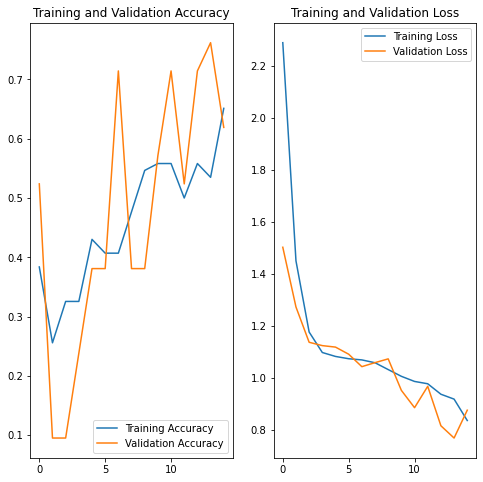

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Test Image

In [28]:
dirpath = '/content/drive/MyDrive/SOS/TRAIN/S/WIN_20220724_06_24_15_Pro.jpg'
model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/model_baru_v2.h5')
img = tf.keras.utils.load_img(
    dirpath, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to S with a 95.30 percent confidence.


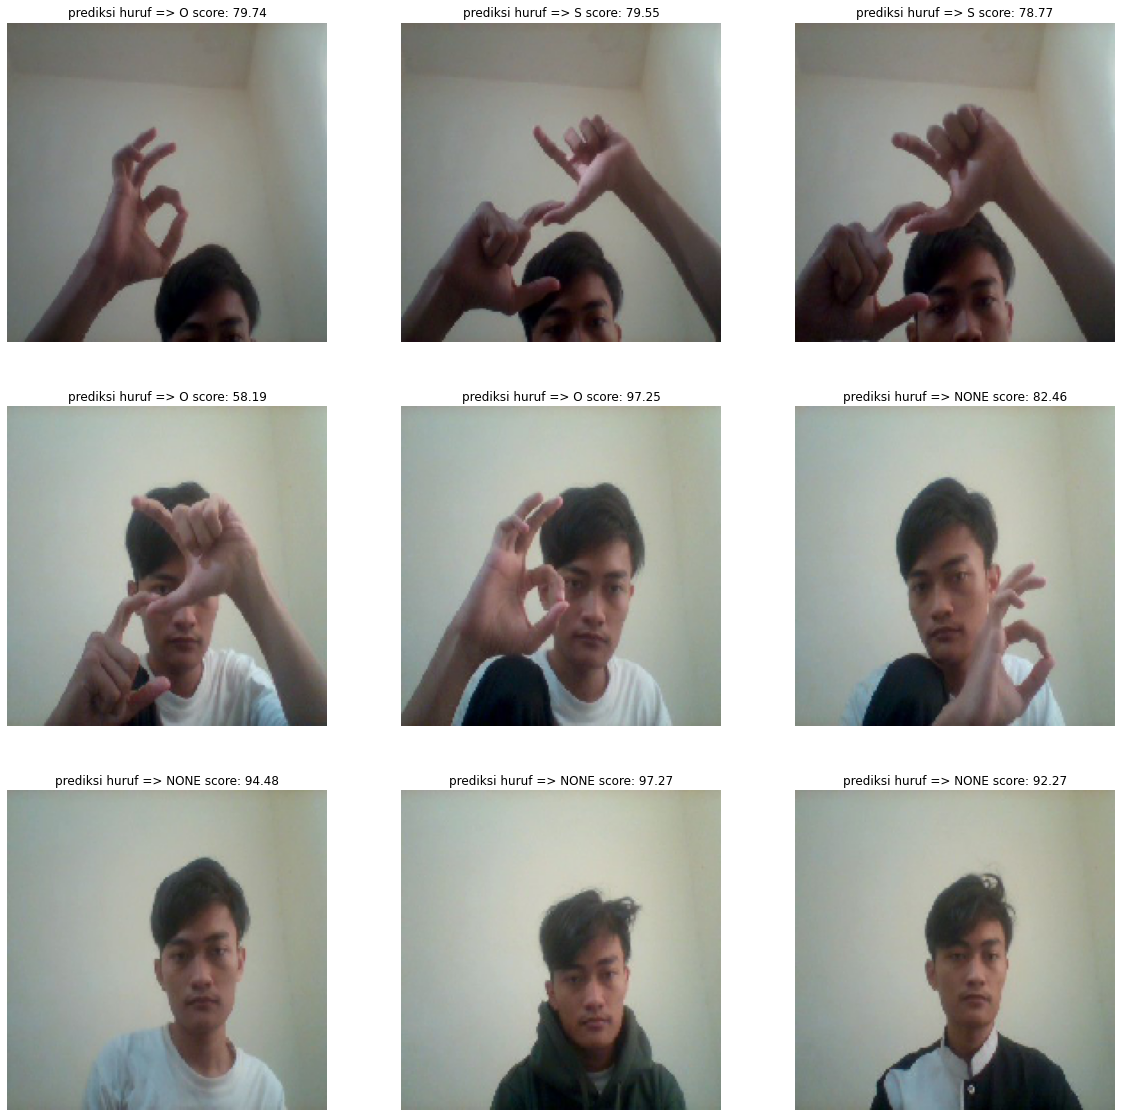

In [1]:
# Test image in folder 'test'
img_height= 180
img_width = 180

size_img = (img_height, img_width, 3)

from keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

directory = '/content/drive/MyDrive/SOS/TEST'
name_class = ['NONE', 'O', 'S']
image_name = []
images = []
collect_img = []
count_img = 9
list_file = sorted(os.listdir(directory))
model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/model_baru_v2.h5')

for img in list_file[:count_img]:
    image_name.append(img)
    img = os.path.join(directory, img)
    img = image.load_img(img, target_size=(size_img))
    img_np = image.img_to_array(img)
    img = np.expand_dims(img_np, axis=0)
    images.append(img)
    collect_img.append(img_np)

images = np.vstack(images)
classes = model.predict(images)

plt.figure(figsize=(20, 20))
for i in range(len(list_file[:count_img][:count_img])):
    idX_class = classes[i]
    ax = plt.subplot(3, 3, i + 1)

    if np.argmax(idX_class) == 0:
      score = tf.nn.softmax(idX_class)
      # print(i+1, image_name[i],'    ', name_class[0])
      plt.imshow(collect_img[i].astype("uint8"))
      # plt.title(image_name[i]+'prediksi huruf => '+name_class[0]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.title('prediksi huruf => '+name_class[0]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.axis("off")

    elif np.argmax(idX_class) == 1:
      score = tf.nn.softmax(idX_class)
      # print(i+1, image_name[i],'    ', name_class[1])
      plt.imshow(collect_img[i].astype("uint8"))
      # plt.title(image_name[i]+'prediksi huruf => '+name_class[1]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.title('prediksi huruf => '+name_class[1]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.axis("off")
      
    elif np.argmax(idX_class) == 2:
      score = tf.nn.softmax(idX_class)
      # print(i+1, image_name[i],'    ', name_class[2])
      plt.imshow(collect_img[i].astype("uint8"))
      # plt.title(image_name[i]+'prediksi huruf => '+name_class[2]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.title('prediksi huruf => '+name_class[2]+' score: '+"{:.2f}".format(100 * np.max(score)))
      plt.axis("off")

In [84]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import html
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io

def jsob_to_image(js_object):
  # decode base64 image
  image_bytes = b64decode(js_object.split(',')[1])
  # convert bytes to numpy array
  img_array = np.frombuffer(image_bytes, dtype=np.uint8)
  # convert numpy array into OpenCV BGR 
  frame = cv2.imdecode(img_array, flags=1)

  return frame

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="blue: red; font-weight: bold;">' +
          'click here to stop the video</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; 
      captureCanvas.height = 480; 
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame() {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
  
            
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame():
  data = eval_js('stream_frame()')
  return data

# Get the webcam stream and forward it to python 
video_stream()

while True:
    frame_js = video_frame()
    if not frame_js:
        break
    img = jsob_to_image(frame_js["img"])

<IPython.core.display.Javascript object>